### Imports

In [ ]:
# !pip install plotly

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import add_Loss, clean_data
import umap
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm, trange
from sklearn.metrics import davies_bouldin_score
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

## Import and clean data 

In [25]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Rabi" # or "Kharif" 

#Path to the dataset
pathData = f"Data\RawDataUnified\RawData_{YEAR}_{SEASON}"
print(pathData)


df = pd.read_csv(pathData)

Data\RawDataUnified\RawData_2019_Rabi


In [26]:
#Clean an add loss to data
df=add_Loss(clean_data(df))
df.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,...,2009 Yield,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,Loss
key,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,1154.0,760.0,561.0,816.0,766.0,670.0,67.0,202.0,746.0,1.078638e+05
andhra pradesh_anantapur_vajrakarur___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,1154.0,944.0,703.0,842.0,775.0,647.0,450.0,627.0,375.0,0.000000e+00
andhra pradesh_anantapur_gooty___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,1154.0,752.0,504.0,1320.0,1223.0,688.0,814.0,379.0,661.0,1.516659e+06
andhra pradesh_anantapur_guntakal___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,1154.0,752.0,504.0,1320.0,1223.0,688.0,814.0,379.0,661.0,1.516659e+06
andhra pradesh_anantapur_pamidi___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,1154.0,752.0,504.0,1320.0,1223.0,688.0,814.0,379.0,661.0,1.516659e+06


## UMAP embeding

In [9]:
#Preprocessing numerical
numerical = df.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = df.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

In [10]:
# from umap import UMAP

fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [11]:
import umap.umap_ as uu

# #Augmenting the numerical embedding with categorical
intersection = uu.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = uu.reset_local_connectivity(intersection)
embedding = uu.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, densmap_kwds="Salut", output_dens=False)

embedding=embedding[0]
np.save(f"embedding_{SEASON}",embedding)  

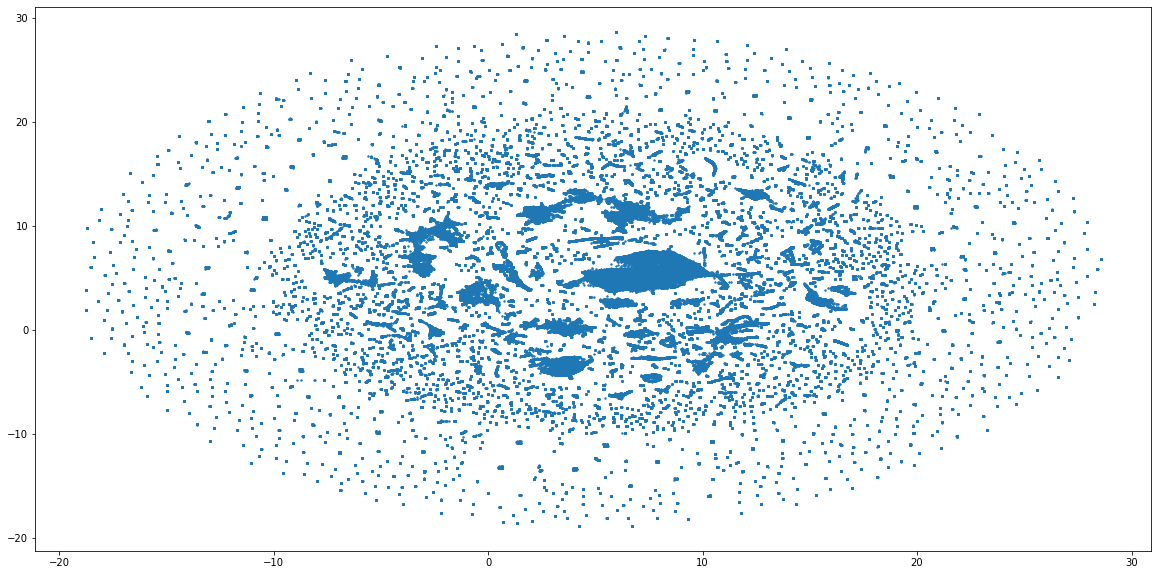

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

## K-Prototypes

In [20]:
# full_data=df.copy(deep=True)
# import kmodes
# from kmodes.kprototypes import KPrototypes

In [21]:
# kprot_data = full_data.copy()
# #Pre-processing
# for c in full_data.select_dtypes(exclude='object').columns:
#     pt = PowerTransformer()
#     kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

# categorical_columns = [1,2,3] #make sure to specify correct indices

# #Actual clustering
# kproto = KPrototypes(n_clusters= 15, init='Cao', n_jobs = 4)
# clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

# #long à tourner : environ 8 min

In [22]:
# #Prints the count of each cluster group
# pd.Series(clusters).value_counts()

13    2984
2     2804
4     1988
11    1925
12    1757
3     1675
8     1526
14    1026
5      975
1      966
7      341
10     268
9      235
6      166
0       99
dtype: int64

In [23]:
# #OPTIONAL: Elbow plot with cost (will take a LONG time)
# costs = []
# n_clusters = []
# clusters_assigned = []

# for i in tqdm(range(2, 25)):
#     try:
#         kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
#         clusters = kproto.fit_predict(kprot_data, categorical=[0, 6, 7, 9, 13])
#         costs.append(kproto.cost_)
#         n_clusters.append(i)
#         clusters_assigned.append(clusters)
#     except:
#         print(f"Can't cluster with {i} clusters")
        
# fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
# fig.show()

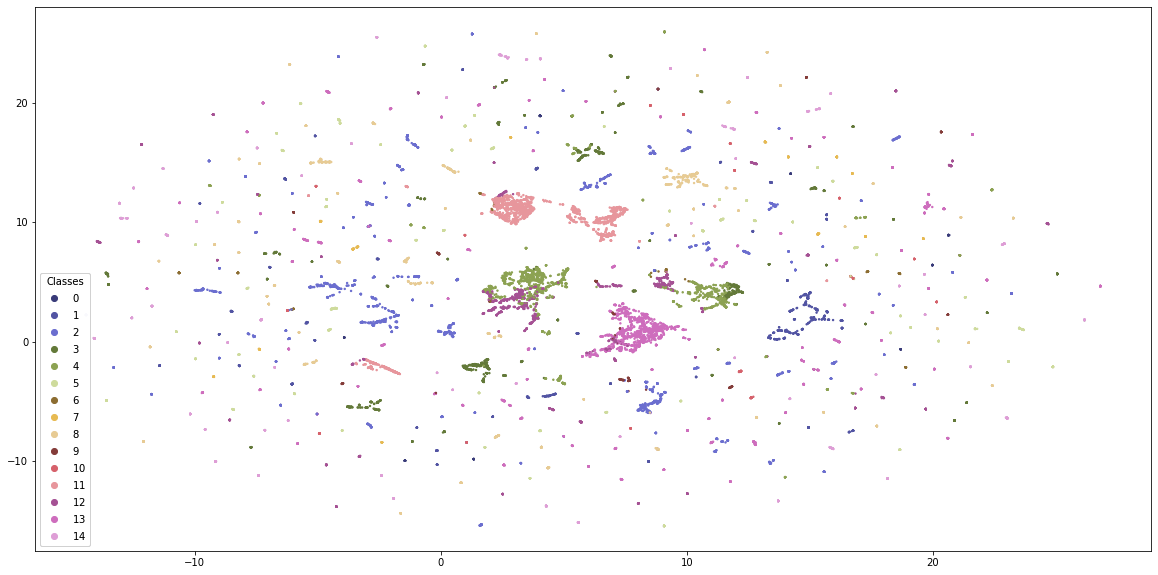

In [24]:
# fig, ax = plt.subplots()
# fig.set_size_inches((20, 10))
# embedding=embedding[0]
# scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(num=15),
#                     loc="lower left", title="Classes")
# ax.add_artist(legend1)

## K-means (for mixed data)

In [27]:
from sklearn.cluster import KMeans
full_data=df.copy(deep=True)

In [28]:
#One-Hot-Encoding
data = pd.get_dummies(full_data)

#Pre-processing
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [29]:
#Actual Clustering

nb_clusters = 10
kmeans = KMeans(init="k-means++", n_clusters=nb_clusters, max_iter=500, n_init=6, random_state=0).fit(data)
kmeans_labels = kmeans.labels_
db_index = davies_bouldin_score(data, kmeans_labels)
print(db_index)

1.7309765739264118


In [ ]:
#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 30)):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=4, max_iter=1000, random_state=0).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

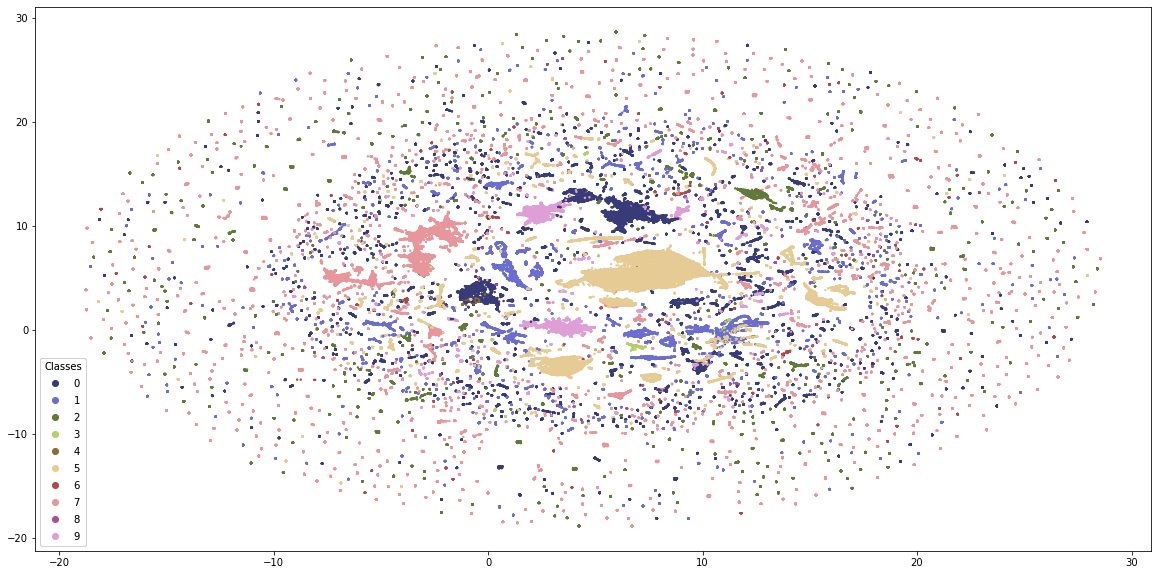

In [31]:
# embedding=embedding[0] #because tuple #comment if load embedding
embedding = np.load(f"Outputs/embedding_{SEASON}.npy")

fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=nb_clusters),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [32]:
labels = pd.DataFrame(kmeans_labels)
databis=full_data.reset_index()
labeledData = pd.concat((databis,labels),axis=1)
labeledData = labeledData.rename({0:'labels'},axis=1)
labeledData=labeledData.set_index(labeledData['key']).drop(columns = ['key'])
labeledData.head()

,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,...,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,Loss,labels
key,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,760.0,561.0,816.0,766.0,670.0,67.0,202.0,746.0,1.078638e+05,0
andhra pradesh_anantapur_vajrakarur___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,944.0,703.0,842.0,775.0,647.0,450.0,627.0,375.0,0.000000e+00,0
andhra pradesh_anantapur_gooty___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,752.0,504.0,1320.0,1223.0,688.0,814.0,379.0,661.0,1.516659e+06,0
andhra pradesh_anantapur_guntakal___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,752.0,504.0,1320.0,1223.0,688.0,814.0,379.0,661.0,1.516659e+06,0
andhra pradesh_anantapur_pamidi___,Bengal Gram (Chana),204.149503,77.473065,30000.0,7.277487e+06,0.8,2275.972276,4629.899829,4377.946588,4312.13996,...,752.0,504.0,1320.0,1223.0,688.0,814.0,379.0,661.0,1.516659e+06,0


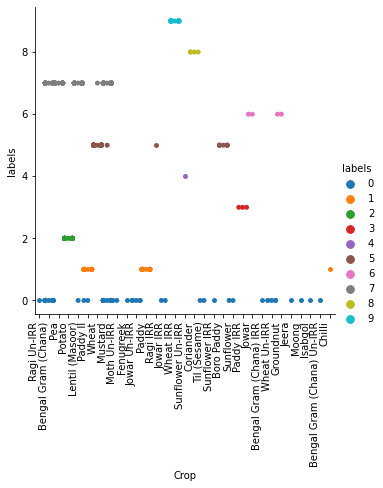

In [33]:
labeledData.columns
sns.catplot(x='Crop', y='labels', kind="swarm", hue='labels', data=labeledData.sample(frac=1, random_state=0)[:500]) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

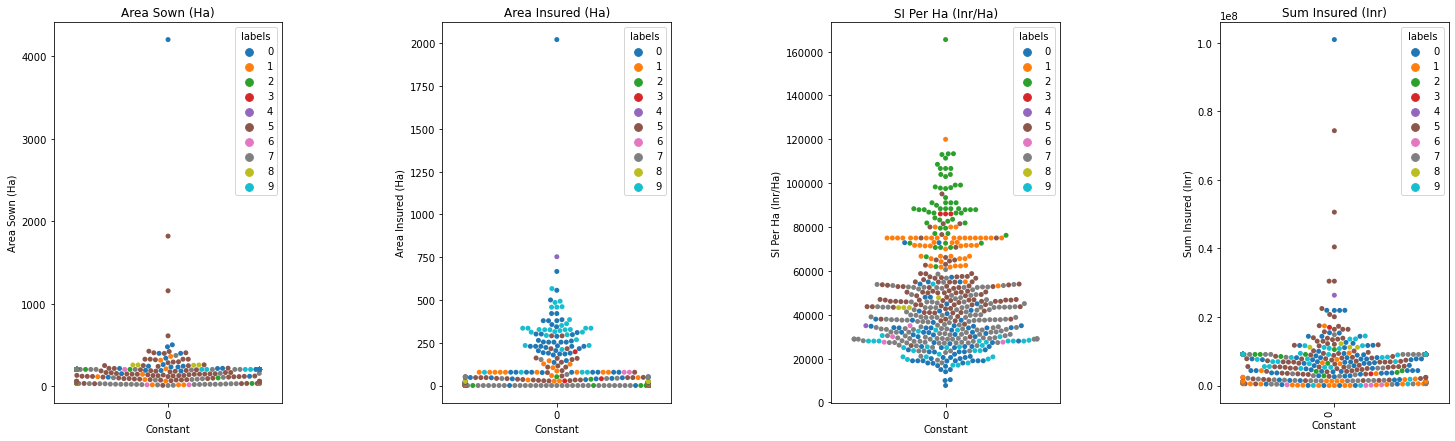

In [34]:
labeledData['Constant'] = 0 #dummy feature for plotting

f, axes = plt.subplots(1, 4, figsize=(25, 7), sharex=False)
f.subplots_adjust(hspace=0.2, wspace=0.7)

for i in trange(5):
    col = labeledData.columns[i]
    # if i ==0 :    
    #     sns.catplot(x=col, y='labels', kind="swarm", hue='labels', data=labeledData.sample(frac=1, random_state=0)[:500],ax=axes[i])
    #     plt.xticks(rotation=90, ha='right')
    if i > 0 :
        ax = sns.swarmplot(x='Constant',y=col,hue='labels',data=labeledData.sample(frac=1, random_state=0)[:500],ax=axes[i-1])
        plt.xticks(rotation=90, ha='right')
        ax.set_title(col)
        
# plt.close(2)
# plt.close(3)
plt.show()

## Implémentation critère cluster

db_index=  2.2210136218733214 ,  k = 5
db_index=  2.228061332219259 ,  k = 6
db_index=  2.217849024841524 ,  k = 7
db_index=  1.7403322756050161 ,  k = 8
db_index=  1.6287798891830318 ,  k = 9
db_index=  1.7309765739264118 ,  k = 10
db_index=  2.0236896857300026 ,  k = 11
db_index=  1.5568519492991753 ,  k = 12
db_index=  1.4879304167882053 ,  k = 13
db_index=  1.4379390800109506 ,  k = 14
db_index=  2.022784479875018 ,  k = 15
db_index=  2.38369183725308 ,  k = 16


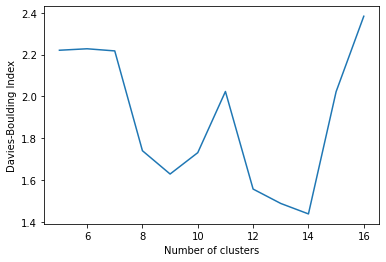

In [35]:
results = {}

for i in range(5,17):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=500, n_init=6, random_state=0).fit(data)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(data, labels)
    print("db_index= ", db_index, ",  k =", i)
    results.update({i: db_index})


plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.show()

#### Otptimal k :

for Rabi : 9 ou 12, 13, 14 \
for Kharif : 10 

à retester